In [1]:
import torch
import numpy as np

import numba as nb
import torchquad
from scipy import optimize, integrate, linalg
from classes import Region, Coordinate, Demands_generator, Demand

# Scipy Implementation for Problem 7

tol = 1e-4
# Instrumental functions for scipy integration
@nb.jit(nopython=True)
def norm_func(x, y):
    return np.sqrt(np.sum(np.square(x - y)))

@nb.jit(nopython=True)
def modified_norm(x_cdnt, i, demands_locations, lambdas):
    return norm_func(x_cdnt, demands_locations[i]) - lambdas[i]

@nb.jit(nopython=True)
def region_indicator(i, x_cdnt, lambdas, demands_locations):
    i_modified_norm = modified_norm(x_cdnt, i, demands_locations, lambdas)
    for j in range(len(lambdas)):
        if i_modified_norm > modified_norm(x_cdnt, j, demands_locations, lambdas):
            return 0
    return 1

@nb.jit(nopython=True)
def categorize_x(x_cdnt, demands_locations, lambdas, v):
    modified_norms = np.array([modified_norm(x_cdnt, i, demands_locations, lambdas) for i in range(demands_locations.shape[0])])
    i = np.argmin(modified_norms)
    return demands_locations[i], v[i+1]

# Integrands of function and derivatives

@nb.njit
def integrand_scipy(r, theta, lambdas, v, demands_locations):
    x_cdnt = np.array([r*np.cos(theta), r*np.sin(theta)])
    xi, vi = categorize_x(x_cdnt, demands_locations, lambdas, v)
    raw_intgrd = 1 / (v[0]*norm_func(x_cdnt, xi) + vi)
    return r*raw_intgrd

@nb.njit
def jac_integrand0_scipy(r, theta, lambdas, v, demands_locations):
    x_cdnt = np.array([r*np.cos(theta), r*np.sin(theta)])
    xi, vi = categorize_x(x_cdnt, demands_locations, lambdas, v)
    the_norm = norm_func(x_cdnt, xi)
    return -r * the_norm/pow(v[0]*the_norm + vi, 2)

'''NOTE: i is the index of v, whose values range from 0 to n
      But j is the index of regions, whose values range from 1 to n.
      For indexes of demands_locations (0 to n-1), we need to offset j by subtracting one.'''

@nb.njit
def jac_integrandj_scipy(r, theta, lambdas, v, demands_locations, j):
    x_cdnt = np.array([r*np.cos(theta), r*np.sin(theta)])
    if region_indicator(j-1, x_cdnt, lambdas, demands_locations) == 0: return 0
    return -r / pow(v[0] * norm_func(x_cdnt, demands_locations[j-1]) + v[j], 2)


def objective_function_scipy(v, demands_locations, lambdas, t, region_radius, thetarange):
    print(f"DEBUG: v is {v, type(v[1])}.")
    start, end = thetarange
    sum_integral, error = integrate.dblquad(integrand_scipy, start, end, lambda _: 0, lambda _: region_radius, args=(lambdas, v, demands_locations), epsabs=tol)
    return 1/4*sum_integral + v[0]*t + np.mean(v[1:])


def objective_jac_scipy(v: list[float], demands_locations: list[list[float]], lambdas: list[float], t: float, region_radius, thetarange):
    start, end = thetarange
    n = demands_locations.shape[0]
    jac = np.zeros(n + 1)
    jac[0] = 1/4 * integrate.dblquad(jac_integrand0_scipy, start, end, lambda _: 0, lambda _: region_radius, args=(lambdas, v, demands_locations), epsabs=tol)[0] + t
    for j in range(1, n+1):
        jac[j] = 1/4 * integrate.dblquad(jac_integrandj_scipy, start, end, lambda _: 0, lambda _: region_radius, args=(lambdas, v, demands_locations, j), epsabs=tol)[0] + 1/n
    print(f"DEBUG: jac is {jac}.")
    return jac


def minimize_problem7_scipy(lambdas, demands, thetarange, t, region_radius):
    # constraints = [optimize.NonlinearConstraint(lambda v: constraint_func(lambdas, demands, v, region_radius), 0, np.inf)]
    demands_locations = np.array([demands[i].get_cdnt() for i in range(len(demands))])
    bounds = optimize.Bounds(1e-12, np.inf)
    result = optimize.minimize(objective_function_scipy, x0=np.append(1e-6, np.ones(demands.shape[0])), args=(demands_locations, lambdas, t, region_radius, thetarange), jac=objective_jac_scipy, method='SLSQP',  bounds=bounds, options={'ftol': tol, 'disp': True})
    return result.x, result.fun

region = Region(1)
depot = Coordinate(2, 0.3)
t, epsilon = 0.25, 0.1

thetarange = (3.147444264116321 - 2*np.pi, 0.00012460881117814946)
demands = np.array([Demand(Coordinate(r = 0.1802696888767692, theta = 4.768809396779301), 1),
           Demand(Coordinate(r = 0.019475241487624584, theta = 5.1413757057591045), 1),
           Demand(Coordinate(r = 0.012780814590608647, theta = 4.478189127165961), 1),
           Demand(Coordinate(r = 0.4873716073198716, theta = 3.7670422583826495), 1),
           Demand(Coordinate(r = 0.10873607186897494, theta = 5.328009178184025), 1),
           Demand(Coordinate(r = 0.8939041702850812, theta = 4.5103794163992506), 1),
           Demand(Coordinate(r = 0.8571542470728296, theta = 3.7828800007876318), 1),
           Demand(Coordinate(r = 0.16508661759522714, theta = 3.4707299112070515), 1),
           Demand(Coordinate(r = 0.6323340138234961, theta = 5.963386240530588), 1),
           Demand(Coordinate(r = 0.020483612791232675, theta = 6.19945137229428), 1),
           Demand(Coordinate(r = 0.15791230667493694, theta = 5.004153427569559), 1)])
demands_locations = np.array([demands[i].get_cdnt() for i in range(len(demands))])
lambdas = np.zeros(demands.shape[0])

v_scipy, obj_scipy = minimize_problem7_scipy(lambdas, demands, thetarange, t, region.radius)
# objective_function(np.append(1e-6, np.ones(demands.shape[0])), demands_locations, lambdas, t, region.radius, thetarange), objective_function_scipy(np.append(1e-6, np.ones(demands.shape[0])), demands_locations, lambdas, t, region.radius, thetarange)

DEBUG: v is (array([1.e-06, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00, 1.e+00,
       1.e+00, 1.e+00, 1.e+00, 1.e+00]), <class 'numpy.float64'>).


d:\anaconda3\envs\hct\Lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
d:\anaconda3\envs\hct\Lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


DEBUG: jac is [ 0.15237174  0.05542283  0.09009648  0.08939359  0.0334797   0.07921427
  0.00754794  0.02935291  0.07738297 -0.02124352  0.09025808  0.07757108].
DEBUG: v is (array([1.00003239e-12, 9.44577173e-01, 9.09903524e-01, 9.10606415e-01,
       9.66520303e-01, 9.20785726e-01, 9.92452058e-01, 9.70647090e-01,
       9.22617031e-01, 1.02124352e+00, 9.09741921e-01, 9.22428915e-01]), <class 'numpy.float64'>).
DEBUG: jac is [ 0.14951366  0.05113648  0.08992754  0.08908092  0.02943194  0.07711544
  0.00627502  0.02557372  0.07501866 -0.0166262   0.09012038  0.07523316].
DEBUG: v is (array([1.00000000e-12, 6.87506923e-01, 4.58009720e-01, 4.62963311e-01,
       8.18522226e-01, 5.33224947e-01, 9.60887936e-01, 8.42043447e-01,
       5.45585984e-01, 1.10490648e+00, 4.56879891e-01, 5.44320683e-01]), <class 'numpy.float64'>).
DEBUG: jac is [ 0.11997267  0.01583285  0.08703979  0.08383296  0.00519164  0.04977739
  0.00062244  0.00409269  0.04546713 -0.00095775  0.08778151  0.04581072].
DEBUG:

d:\anaconda3\envs\hct\Lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


DEBUG: v is (array([1.00000000e-12, 6.63001776e-01, 4.12208748e-01, 4.16666980e-01,
       8.05205597e-01, 4.91043154e-01, 9.58145159e-01, 8.30556118e-01,
       5.05148590e-01, 1.11203889e+00, 4.11191902e-01, 5.03724552e-01]), <class 'numpy.float64'>).
DEBUG: jac is [1.13988924e-01 1.01806725e-02 8.61360241e-02 8.21736853e-02
 2.33284677e-03 4.24076863e-02 1.04793274e-04 1.67384425e-03
 3.79012071e-02 2.16953115e-04 8.70479885e-02 3.82480396e-02].
DEBUG: v is (array([1.00004105e-12, 4.90220573e-01, 1.00000000e-12, 1.00000000e-12,
       7.12222424e-01, 1.53980672e-01, 9.38720583e-01, 7.50239664e-01,
       1.88348893e-01, 1.16356664e+00, 1.00000000e-12, 1.85251626e-01]), <class 'numpy.float64'>).


d:\anaconda3\envs\hct\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


DEBUG: v is (array([1.00000411e-12, 6.45723656e-01, 3.70987873e-01, 3.75000282e-01,
       7.95907279e-01, 4.57336906e-01, 9.56202702e-01, 8.22524473e-01,
       4.73468620e-01, 1.11719167e+00, 3.70072712e-01, 4.71877259e-01]), <class 'numpy.float64'>).
DEBUG: jac is [ 1.08597415e-01  5.80292282e-03  8.50120953e-02  8.01253405e-02
  2.51065626e-04  3.49937594e-02 -2.64504093e-04 -7.73636691e-05
  3.05704029e-02  1.05300350e-03  8.61419897e-02  3.09008899e-02].
DEBUG: v is (array([1.00000000e-12, 5.25849481e-01, 1.00003339e-12, 1.00000000e-12,
       7.31637644e-01, 1.96752982e-01, 9.42542985e-01, 7.66896298e-01,
       2.33050359e-01, 1.15422046e+00, 1.00000000e-12, 2.29892168e-01]), <class 'numpy.float64'>).
DEBUG: v is (array([1.00000369e-12, 6.33736238e-01, 3.33889086e-01, 3.37500254e-01,
       7.89480316e-01, 4.31278514e-01, 9.54836730e-01, 8.16961655e-01,
       4.49426794e-01, 1.12089454e+00, 3.33065441e-01, 4.47678750e-01]), <class 'numpy.float64'>).
DEBUG: jac is [ 0.10392231 

d:\anaconda3\envs\hct\Lib\site-packages\scipy\integrate\_quadpack_py.py:1233: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


DEBUG: v is (array([1.00001150e-12, 6.10797567e-01, 1.77442350e-01, 1.80977366e-01,
       7.78189527e-01, 3.68945116e-01, 9.52426943e-01, 8.07238358e-01,
       3.93289141e-01, 1.12782729e+00, 1.77004631e-01, 3.91107312e-01]), <class 'numpy.float64'>).
DEBUG: jac is [ 0.08818182 -0.00420852  0.06512514  0.04457783 -0.0039248   0.00499582
 -0.00098883 -0.00355584  0.00345922  0.0027397   0.0700705   0.0035567 ].
DEBUG: v is (array([1.00000000e-12, 6.07446970e-01, 1.00000563e-12, 4.73618610e-02,
       7.79851299e-01, 3.40920088e-01, 9.53091996e-01, 8.09019777e-01,
       3.68382742e-01, 1.12617648e+00, 1.00003339e-12, 3.66053244e-01]), <class 'numpy.float64'>).
DEBUG: v is (array([1.00001035e-12, 6.10462507e-01, 1.59698115e-01, 1.67615815e-01,
       7.78355704e-01, 3.66142613e-01, 9.52493448e-01, 8.07416500e-01,
       3.90798501e-01, 1.12766221e+00, 1.59304168e-01, 3.88601905e-01]), <class 'numpy.float64'>).
DEBUG: jac is [ 0.08672544 -0.00431296  0.05906753  0.03689629 -0.00388431  

In [2]:
# Torchquad Implementation for Problem 7
import torch
import numpy as np

import numba as nb
import torchquad
from scipy import optimize
from classes import Region, Coordinate, Demand

from torchquad import set_up_backend
set_up_backend("torch", data_type="float32")
def integrand7(X, lambdas, v, demands_locations):
    '''
    X is a n-by-2 matrix, the first column is r, the second column is theta.
    '''
    dtype = X.dtype
    print(f"lambdas is {lambdas}., v0 is {v[0]}, v1 is {v[1:]}.")
    lambdas, v1, v0 = torch.tensor(lambdas, dtype=dtype), torch.tensor(v[1:], dtype=dtype), v[0]
    # print(f"lambdas is {lambdas}., v0 is {v0}, v1 is {v1}.")
    demands_locations = torch.tensor(demands_locations, dtype=dtype)
    x_cdnt = X.clone()
    x_cdnt[:, 0] = X[:, 0]*torch.cos(x_cdnt[:, 1])
    x_cdnt[:, 1] = X[:, 0]*torch.sin(x_cdnt[:, 1])
    norms = torch.cdist(x_cdnt, demands_locations, p=2)
    modified_norms, modified_norms_indices = torch.min(norms - lambdas, dim=1)
    raw_intgrd = 1 / (v0*norms[torch.arange(norms.shape[0]), modified_norms_indices] + v1[modified_norms_indices])
    if raw_intgrd.is_complex(): 
        # print(f"raw_intgrd is complex. {raw_intgrd}")
        raise ValueError
    return X[:, 0]*raw_intgrd

def jac_integrand07(X, lambdas, v, demands_locations):
    '''
    X is a n-by-2 matrix, the first column is r, the second column is theta.
    '''
    dtype = X.dtype
    lambdas, v1, v0 = torch.tensor(lambdas, dtype=dtype), torch.tensor(v[1:], dtype=dtype), v[0]
    demands_locations = torch.tensor(demands_locations, dtype=dtype)
    x_cdnt = X.clone()
    x_cdnt[:, 0] = X[:, 0]*torch.cos(x_cdnt[:, 1])
    x_cdnt[:, 1] = X[:, 0]*torch.sin(x_cdnt[:, 1])
    norms = torch.cdist(x_cdnt, demands_locations, p=2)
    modified_norms, modified_norms_indices = torch.min(norms - lambdas, dim=1)
    cooresponding_norms = norms[torch.arange(norms.shape[0]), modified_norms_indices]
    raw_intgrd = cooresponding_norms / torch.square(v0*cooresponding_norms + v1[modified_norms_indices])
    return -X[:, 0] * raw_intgrd

def jac_integrandj7(X, lambdas, v, demands_locations, j):
    '''
    X is a n-by-2 matrix, the first column is r, the second column is theta.
    '''
    dtype = X.dtype
    lambdas, v1, v0 = torch.tensor(lambdas, dtype=dtype), torch.tensor(v[1:], dtype=dtype), v[0]
    demands_locations = torch.tensor(demands_locations, dtype=dtype)
    x_cdnt = X.clone()
    x_cdnt[:, 0] = X[:, 0]*torch.cos(x_cdnt[:, 1])
    x_cdnt[:, 1] = X[:, 0]*torch.sin(x_cdnt[:, 1])
    norms = torch.cdist(x_cdnt, demands_locations, p=2)
    modified_norms, modified_norms_indices = torch.min(norms - lambdas, dim=1)
    maskj = modified_norms_indices != j-1
    cooresponding_norms = norms[torch.arange(norms.shape[0]), modified_norms_indices]
    raw_intgrd = 1 / torch.square(v0*cooresponding_norms + v1[modified_norms_indices])
    masked_intgrd = -X[:, 0] * raw_intgrd
    masked_intgrd[maskj] = 0
    return masked_intgrd

def objective_function7(v, demands_locations, lambdas, t, region_radius, thetarange):
    # print(f"DEBUG: v is {v, type(v[1])}.")
    # v = np.real(v)
    start, end = thetarange
    simpson = torchquad.Simpson()
    sum_integral = simpson.integrate(lambda X: integrand7(X, lambdas, v, demands_locations), dim=2, N=10000001, integration_domain=[[0, region_radius], [start, end]], backend='torch').item()
    # print(f"sum_integral is {sum_integral}. with type {type(sum_integral)}")
    return 1/4*sum_integral + v[0]*t + np.mean(v[1:])

def objective_jac7(v, demands_locations, lambdas, t, region_radius, thetarange):
    start, end = thetarange
    n = demands_locations.shape[0]
    jac = np.zeros(n + 1)
    simpson = torchquad.Simpson()
    jac[0] = 1/4 * simpson.integrate(lambda X: jac_integrand07(X, lambdas, v, demands_locations), dim=2, N=10000001, integration_domain=[[0, region_radius], [start, end]], backend='torch').item() + t

    # The precompiled version is even slower, so we don't use it.
    # for j in torch.range(1, n): # notice torch.range is inclusive on both ends, hence we use n as upper bound
    #     if j == 1:
    #         simpsonj_compiled = torch.jit.trace(
    #             lambda vj_index: simpson.integrate(lambda X: jac_integrandj(X, lambdas, v, demands_locations, vj_index), dim=2, N=10000001, integration_domain=[[0, region_radius], [start, end]], backend='torch'),
    #             (j,)
    #                 )
    #     jac[int(j.item())] = 1/4 * simpsonj_compiled(j).item() + 1/n


    for j in range(1, n+1):
        jac[j] = 1/4 * simpson.integrate(lambda X: jac_integrandj7(X, lambdas, v, demands_locations, j), dim=2, N=10000001, integration_domain=[[0, region_radius], [start, end]], backend='torch').item() + 1/n
    print(f"DEBUG: jac is {jac}.")
    return jac


def minimize_problem7(lambdas, demands, thetarange, t, region_radius, tol=1e-4):
    # constraints = [optimize.NonlinearConstraint(lambda v: constraint_func(lambdas, demands, v, region_radius), 0, np.inf)]
    demands_locations = np.array([demands[i].get_cdnt() for i in range(len(demands))])
    bounds = optimize.Bounds(0, np.inf)
    result = optimize.minimize(objective_function7, x0=np.append(1e-6, np.ones(demands.shape[0])), args=(demands_locations, lambdas, t, region_radius, thetarange), jac=objective_jac7, method='SLSQP',  bounds=bounds, options={'ftol': tol, 'disp': True})
    return result.x, result.fun


region = Region(1)
depot = Coordinate(2, 0.3)
t, epsilon = 0.25, 0.1

thetarange = (3.147444264116321 - 2*np.pi, 0.00012460881117814946)
demands = np.array([Demand(Coordinate(r = 0.1802696888767692, theta = 4.768809396779301), 1),
           Demand(Coordinate(r = 0.019475241487624584, theta = 5.1413757057591045), 1),
           Demand(Coordinate(r = 0.012780814590608647, theta = 4.478189127165961), 1),
           Demand(Coordinate(r = 0.4873716073198716, theta = 3.7670422583826495), 1),
           Demand(Coordinate(r = 0.10873607186897494, theta = 5.328009178184025), 1),
           Demand(Coordinate(r = 0.8939041702850812, theta = 4.5103794163992506), 1),
           Demand(Coordinate(r = 0.8571542470728296, theta = 3.7828800007876318), 1),
           Demand(Coordinate(r = 0.16508661759522714, theta = 3.4707299112070515), 1),
           Demand(Coordinate(r = 0.6323340138234961, theta = 5.963386240530588), 1),
           Demand(Coordinate(r = 0.020483612791232675, theta = 6.19945137229428), 1),
           Demand(Coordinate(r = 0.15791230667493694, theta = 5.004153427569559), 1)])
demands_locations = np.array([demands[i].get_cdnt() for i in range(len(demands))])
lambdas = np.zeros(demands.shape[0])

v_torch, obj_torch = minimize_problem7(lambdas, demands, thetarange, t, region.radius)

d:\anaconda3\envs\hct\Lib\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)
d:\anaconda3\envs\hct\Lib\site-packages\torchquad\integration\simpson.py:77: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 3162 -> 3161.
  warnings.warn(
d:\anaconda3\envs\hct\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


lambdas is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]., v0 is 1e-06, v1 is [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.].


d:\anaconda3\envs\hct\Lib\site-packages\torchquad\integration\utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


DEBUG: jac is [ 0.1523772   0.05538272  0.09007328  0.08939176  0.03337793  0.0790582
  0.00755116  0.0293338   0.07736579 -0.02126194  0.09025265  0.07751708].
lambdas is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]., v0 is 0.0, v1 is [0.94461728 0.90992672 0.91060824 0.96662207 0.9209418  0.99244884
 0.9706662  0.92263421 1.02126194 0.90974735 0.92248292].
DEBUG: jac is [ 0.14952369  0.05109478  0.08989961  0.08907924  0.02933614  0.07693618
  0.00627783  0.02555588  0.07499926 -0.01663999  0.09011595  0.07517182].
lambdas is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]., v0 is 0.0, v1 is [0.68775438 0.45816958 0.46297005 0.81910422 0.53427808 0.96087032
 0.84215108 0.54569756 1.10499513 0.45690403 0.54467966].
DEBUG: jac is [ 0.120067    0.01580142  0.08692749  0.08383007  0.00516089  0.049393
  0.00062367  0.00408773  0.04542906 -0.00095806  0.08776465  0.04576886].
lambdas is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]., v0 is 1.0326506099275403e-16, v1 is [4.42965098e-01 5.55111512e-17 3.88578059e-16 6.86412

In [3]:
print(f"v_scipy is {v_scipy}, obj_scipy is {obj_scipy}.")
print(f"v_torch is {v_torch}, obj_torch is {obj_torch}.")

v_scipy is [1.00000393e-12 6.14831292e-01 9.65512921e-02 1.34037756e-01
 7.83611262e-01 3.58982717e-01 9.53970984e-01 8.12295322e-01
 3.85090314e-01 1.12336499e+00 8.45504191e-02 3.82805938e-01], obj_scipy is 1.0460955907232954.
v_torch is [0.         0.61838487 0.0959722  0.12811131 0.78715137 0.36121434
 0.95469297 0.81500002 0.38568695 1.12128328 0.09069179 0.38356752], obj_torch is 1.0460490914345333.


In [4]:
v = np.array([3.46391326e-18, 6.14822318e-01, 9.65945463e-02, 1.34070553e-01,
        7.83603013e-01, 3.58985231e-01, 9.53966571e-01, 8.12286499e-01,
        3.85096938e-01, 1.12337054e+00, 8.45804876e-02, 3.82777536e-01])
objective_function7(v, demands_locations, lambdas, t, region.radius, thetarange), objective_function_scipy(v, demands_locations, lambdas, t, region.radius, thetarange)

lambdas is [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]., v0 is 3.46391326e-18, v1 is [0.61482232 0.09659455 0.13407055 0.78360301 0.35898523 0.95396657
 0.8122865  0.38509694 1.12337054 0.08458049 0.38277754].
DEBUG: v is (array([3.46391326e-18, 6.14822318e-01, 9.65945463e-02, 1.34070553e-01,
       7.83603013e-01, 3.58985231e-01, 9.53966571e-01, 8.12286499e-01,
       3.85096938e-01, 1.12337054e+00, 8.45804876e-02, 3.82777536e-01]), <class 'numpy.float64'>).


(1.0460611325972602, 1.046095816563968)

In [5]:
# Scipy implementation for Problem 14
import numpy as np
import torch
import numba as nb
import torchquad
from scipy import optimize, integrate, linalg
from classes import Region, Coordinate, Demands_generator, Demand

tol = 1e-3
@nb.jit(nopython=True)
def norm_func(x, y):
    return np.sqrt(np.sum(np.square(x - y)))

@nb.jit(nopython=True)
def min_modified_norm(x_cdnt, demands_locations, lambdas):
    n = demands_locations.shape[0]
    norms = np.array([norm_func(x_cdnt, demands_locations[i]) - lambdas[i] for i in range(n)])
    return np.min(norms)

@nb.njit
def integrand_scipy(r: float, theta: float, v, demands_locations, lambdas):
    # Calculate a list of ||x-xi|| - lambda_i
    x_cdnt = np.array([r*np.cos(theta), r*np.sin(theta)])
    raw_intgrd = 1/(4*(v[0]*min_modified_norm(x_cdnt, demands_locations, lambdas) + v[1]))
    return raw_intgrd*r    # r as Jacobian

@nb.njit
def jac_integrand0_scipy(r: float, theta: float, v, demands_locations, lambdas):
    x_cdnt = np.array([r*np.cos(theta), r*np.sin(theta)])
    the_min_modified_norm = min_modified_norm(x_cdnt, demands_locations, lambdas)
    raw_intgrd = -4*the_min_modified_norm / pow(4*(v[0]*the_min_modified_norm + v[1]), 2)
    return raw_intgrd*r

@nb.njit
def jac_integrand1_scipy(r: float, theta: float, v, demands_locations, lambdas):
    x_cdnt = np.array([r*np.cos(theta), r*np.sin(theta)])
    the_min_modified_norm = min_modified_norm(x_cdnt, demands_locations, lambdas)
    raw_intgrd = -4 / pow(4*(v[0]*the_min_modified_norm + v[1]), 2)
    return raw_intgrd*r

def objective_function_scipy(v, demands_locations, lambdas, t, region_radius, thetarange):
    start, end = thetarange
    area, error = integrate.dblquad(integrand_scipy, start, end, lambda _: 0, lambda _: region_radius, args=(v, demands_locations, lambdas), epsabs=tol)
    return area + v[0]*t + v[1]

def objective_jac_scipy(v, demands_locations, lambdas, t, region_radius, thetarange):
    start, end = thetarange
    area0, error0 = integrate.dblquad(jac_integrand0_scipy, start, end, lambda _: 0, lambda _: region_radius, args=(v, demands_locations, lambdas), epsabs=tol)
    area1, error1 = integrate.dblquad(jac_integrand1_scipy, start, end, lambda _: 0, lambda _: region_radius, args=(v, demands_locations, lambdas), epsabs=tol)
    return np.array([area0 + t, area1 + 1])

def constraint_and_jac(demands_locations, lambdas, region_radius):
    return np.array([min(-lambdas), 1]), np.array([min(-lambdas), 1])

def minimize_problem14_scipy(demands, thetarange, lambdas, t, region_radius):
    demands_locations = np.array([demands[i].get_cdnt() for i in range(len(demands))])
    constraint_coeff, constraint_jac = constraint_and_jac(demands_locations, lambdas, region_radius)
    constraints_dict = {'type': 'ineq', 'fun': lambda v: constraint_coeff @ v, 'jac': lambda _: constraint_jac}
    bound = optimize.Bounds(0.0001, np.inf)
    result = optimize.minimize(objective_function_scipy, x0=np.array([0.0001, 1]), args=(demands_locations, lambdas, t, region_radius, thetarange), jac=objective_jac_scipy, method='SLSQP', bounds=bound, constraints=constraints_dict)
    return result.x, result.fun

region = Region(1)
depot = Coordinate(2, 0.3)
t, epsilon = 0.25, 0.1

thetarange = (3.147444264116321 - 2*np.pi, 0.00012460881117814946)
demands = np.array([Demand(Coordinate(r = 0.1802696888767692, theta = 4.768809396779301), 1),
           Demand(Coordinate(r = 0.019475241487624584, theta = 5.1413757057591045), 1),
           Demand(Coordinate(r = 0.012780814590608647, theta = 4.478189127165961), 1),
           Demand(Coordinate(r = 0.4873716073198716, theta = 3.7670422583826495), 1),
           Demand(Coordinate(r = 0.10873607186897494, theta = 5.328009178184025), 1),
           Demand(Coordinate(r = 0.8939041702850812, theta = 4.5103794163992506), 1),
           Demand(Coordinate(r = 0.8571542470728296, theta = 3.7828800007876318), 1),
           Demand(Coordinate(r = 0.16508661759522714, theta = 3.4707299112070515), 1),
           Demand(Coordinate(r = 0.6323340138234961, theta = 5.963386240530588), 1),
           Demand(Coordinate(r = 0.020483612791232675, theta = 6.19945137229428), 1),
           Demand(Coordinate(r = 0.15791230667493694, theta = 5.004153427569559), 1)])
demands_locations = np.array([demands[i].get_cdnt() for i in range(len(demands))])
lambdas = np.zeros(demands.shape[0])

v_scipy, obj_scipy = minimize_problem14_scipy(demands, thetarange, lambdas, t, region.radius)

In [6]:
# Torchquad implementation for Problem 14
tol = 1e-3
def integrand(X, v, demands_locations, lambdas):
    '''
    X is a n-by-2 matrix, the first column is r, the second column is theta.
    '''
    dtype = X.dtype
    lambdas, v1, v0 = torch.tensor(lambdas, dtype=dtype), torch.tensor(v[1:], dtype=dtype), v[0]
    demands_locations = torch.tensor(demands_locations, dtype=dtype)
    x_cdnt = X.clone()
    x_cdnt[:, 0] = X[:, 0]*torch.cos(x_cdnt[:, 1])
    x_cdnt[:, 1] = X[:, 0]*torch.sin(x_cdnt[:, 1])
    norms = torch.cdist(x_cdnt, demands_locations, p=2)
    modified_norms, modified_norms_indices = torch.min(norms - lambdas, dim=1)
    raw_intgrd = 1 / (v[0]*modified_norms + v[1])
    return X[:, 0]*raw_intgrd    # r as Jacobian


def jac_integrand0(X, v, demands_locations, lambdas):
    '''
    X is a n-by-2 matrix, the first column is r, the second column is theta.
    '''
    dtype = X.dtype
    lambdas, v1, v0 = torch.tensor(lambdas, dtype=dtype), torch.tensor(v[1:], dtype=dtype), v[0]
    demands_locations = torch.tensor(demands_locations, dtype=dtype)
    x_cdnt = X.clone()
    x_cdnt[:, 0] = X[:, 0]*torch.cos(x_cdnt[:, 1])
    x_cdnt[:, 1] = X[:, 0]*torch.sin(x_cdnt[:, 1])
    norms = torch.cdist(x_cdnt, demands_locations, p=2)
    modified_norms, modified_norms_indices = torch.min(norms - lambdas, dim=1)
    raw_intgrd = -modified_norms / torch.square(v[0]*modified_norms + v[1])
    return X[:, 0]*raw_intgrd


def jac_integrand1(X, v, demands_locations, lambdas):
    '''
    X is a n-by-2 matrix, the first column is r, the second column is theta.
    '''
    dtype = X.dtype
    lambdas, v1, v0 = torch.tensor(lambdas, dtype=dtype), torch.tensor(v[1:], dtype=dtype), v[0]
    demands_locations = torch.tensor(demands_locations, dtype=dtype)
    x_cdnt = X.clone()
    x_cdnt[:, 0] = X[:, 0]*torch.cos(x_cdnt[:, 1])
    x_cdnt[:, 1] = X[:, 0]*torch.sin(x_cdnt[:, 1])
    norms = torch.cdist(x_cdnt, demands_locations, p=2)
    modified_norms, modified_norms_indices = torch.min(norms - lambdas, dim=1)
    raw_intgrd = -1 / torch.square(v[0]*modified_norms + v[1])
    return X[:, 0]*raw_intgrd

def objective_function(v, demands_locations, lambdas, t, region_radius, thetarange):
    start, end = thetarange
    simpson = torchquad.Simpson()
    area = simpson.integrate(lambda X: integrand(X, v, demands_locations, lambdas), dim=2, N=1000001, integration_domain=[[0, region_radius], [start, end]], backend='torch').item()
    return area/4 + v[0]*t + v[1]

def objective_jac(v, demands_locations, lambdas, t, region_radius, thetarange):
    start, end = thetarange
    simpson = torchquad.Simpson()
    area0 = simpson.integrate(lambda X: jac_integrand0(X, v, demands_locations, lambdas), dim=2, N=1000001, integration_domain=[[0, region_radius], [start, end]], backend='torch').item()
    area1 = simpson.integrate(lambda X: jac_integrand1(X, v, demands_locations, lambdas), dim=2, N=1000001, integration_domain=[[0, region_radius], [start, end]], backend='torch').item()
    return np.array([area0/4 + t, area1/4 + 1])

def constraint_and_jac(demands_locations, lambdas, region_radius):
    return np.array([min(-lambdas), 1]), np.array([min(-lambdas), 1])

def minimize_problem14(demands, thetarange, lambdas, t, region_radius):
    demands_locations = np.array([demands[i].get_cdnt() for i in range(len(demands))])
    constraint_coeff, constraint_jac = constraint_and_jac(demands_locations, lambdas, region_radius)
    constraints_dict = {'type': 'ineq', 'fun': lambda v: constraint_coeff @ v, 'jac': lambda _: constraint_jac}
    bound = optimize.Bounds(0, np.inf)
    result = optimize.minimize(objective_function, x0=np.array([0., 1]), args=(demands_locations, lambdas, t, region_radius, thetarange), jac=objective_jac, method='SLSQP', bounds=bound, constraints=constraints_dict)
    return result.x, result.fun

region = Region(1)
depot = Coordinate(2, 0.3)
t, epsilon = 0.25, 0.1

thetarange = (3.147444264116321 - 2*np.pi, 0.00012460881117814946)
demands = np.array([Demand(Coordinate(r = 0.1802696888767692, theta = 4.768809396779301), 1),
           Demand(Coordinate(r = 0.019475241487624584, theta = 5.1413757057591045), 1),
           Demand(Coordinate(r = 0.012780814590608647, theta = 4.478189127165961), 1),
           Demand(Coordinate(r = 0.4873716073198716, theta = 3.7670422583826495), 1),
           Demand(Coordinate(r = 0.10873607186897494, theta = 5.328009178184025), 1),
           Demand(Coordinate(r = 0.8939041702850812, theta = 4.5103794163992506), 1),
           Demand(Coordinate(r = 0.8571542470728296, theta = 3.7828800007876318), 1),
           Demand(Coordinate(r = 0.16508661759522714, theta = 3.4707299112070515), 1),
           Demand(Coordinate(r = 0.6323340138234961, theta = 5.963386240530588), 1),
           Demand(Coordinate(r = 0.020483612791232675, theta = 6.19945137229428), 1),
           Demand(Coordinate(r = 0.15791230667493694, theta = 5.004153427569559), 1)])
demands_locations = np.array([demands[i].get_cdnt() for i in range(len(demands))])
lambdas = np.zeros(demands.shape[0])

v_torch, obj_torch = minimize_problem14(demands, thetarange, lambdas, t, region.radius)

d:\anaconda3\envs\hct\Lib\site-packages\torchquad\integration\simpson.py:77: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 1000 -> 999.
  warnings.warn(
d:\anaconda3\envs\hct\Lib\site-packages\torchquad\integration\utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


In [7]:
print(f"v_scipy is {v_scipy}, obj_scipy is {obj_scipy}.")
print(f"v_torch is {v_torch}, obj_torch is {obj_torch}.")

v_scipy is [1.00000000e-04 6.26068083e-01], obj_scipy is 1.2521713310658997.
v_torch is [0.         0.62608986], obj_torch is 1.252165009160772.


In [2]:
import time
import torch
import torchquad
from problem14 import minimize_problem14
from problem7 import minimize_problem7
import torch
import numpy as np

import numba as nb
import torchquad
from scipy import optimize
from classes import Region, Coordinate, Demand, Polyhedron

from torchquad import set_up_backend
set_up_backend("torch", data_type="float32")

def findWorstTSPDensity(region, demands, thetarange, t, epsilon, tol: float=1e-4):
    '''
    Algorithm by Carlsson, Behroozl, and Mihic, 2018.
    Code by Yidi Miao, 2023.

    This algorithm (find the worst TSP density) takes as input a compact planar region containing 
    a set of n distinct points, a distance threshold t, and a tolerance epsilon.

    Input: A compact, planar region Rg containing a set of distinct points x1, x2,..., xn, which are 
    interpreted as an empirical distribution f_hat, a distance parameter t, and a tolerance epsilon.

    Output: An epsilon-approximation of the distribution f* that maximizes iint_Rg sqrt(f(x)) dA 
    subject to the constraint that D(f_hat, f) <= t.

    This is a standard analytic center cutting plane method applied to problem (13), which has an 
    n-dimensional variable space.
    '''

    start, end = thetarange
    n = demands.shape[0]
    simpson = torchquad.Simpson()
    UB, LB = np.inf, -np.inf
    UB_lst, LB_lst = [], []
    lambdas_bar = np.zeros(n)
    polyhedron = Polyhedron(np.eye(n), region.diam*np.ones(n), np.ones((1, n)), 0, n)
    k = 1
    while (UB - LB > epsilon and k < 100):
        print(f'Looking for worst-distribution on {[start, end]}:\nIteration {k} begins: \n')
        starttime = time.time()
        try:
            result = polyhedron.find_analytic_center(lambdas_bar)
            if result == "EMPTY": return lambda X: f_tilde(X, demands_locations, lambdas_bar, v_tilde), UB_lst, LB_lst
            lambdas_bar, lambdas_bar_func_val = result
        except Exception as e:
            print(f"An error occurred: {e}")
            return polyhedron, lambdas_bar, v_tilde

        print(f'Find analytic center: Lambdas_bar is {lambdas_bar}, with value {lambdas_bar_func_val}, took {time.time() - starttime}s.\n')
        with open("./timerecords/find_analytic_center.txt", "a") as f:
            f.write(f"{time.time() - starttime}\n")

        demands_locations = np.array([demands[i].get_cdnt() for i in range(len(demands))])

        '''Build an upper bounding f_bar for the original problem (4).'''
        time_before_minimize_problem14 = time.time()
        v_bar, problem14_func_val = minimize_problem14(demands, thetarange, lambdas_bar, t, region.radius)
        with open("./timerecords/minimize_problem14.txt", "a") as f:
            f.write(f"{time.time() - time_before_minimize_problem14}\n")

        time_before_ub_integral = time.time()
        upper_integrand = lambda X: X[:, 0]*torch.sqrt(f_bar(X, demands_locations, lambdas_bar, v_bar))
        UB = simpson.integrate(upper_integrand, dim=2, N=999999, integration_domain=[[0, region.radius],[start, end]], backend='torch').item()
        with open("./timerecords/ub_integral.txt", "a") as f:
            f.write(f"{time.time() - time_before_ub_integral}\n")

        print(f'UB is {UB}, took {time.time() - starttime}s.\n')

        if UB < 0:
            print(f'UB is negative: {UB}.')
            print(f'v_bar is {v_bar}, problem14_func_val is {problem14_func_val}.')
            break

        '''Build an lower bounding f_tilde that us feasible for (4) by construction.'''
        time_before_minimize_problem7 = time.time()
        v_tilde, problem7_func_val = minimize_problem7(lambdas_bar, demands, thetarange, t, region.radius, tol)
        with open("./timerecords/minimize_problem7.txt", "a") as f:
            f.write(f"{time.time() - time_before_minimize_problem7}\n")

        time_before_lb_integral = time.time()
        lower_integrand = lambda X: X[:, 0]*torch.sqrt(f_tilde(X, demands_locations, lambdas_bar, v_tilde))
        LB = simpson.integrate(lower_integrand, dim=2, N=999999, integration_domain=[[0, region.radius],[start, end]], backend='torch').item()
        with open("./timerecords/lb_integral.txt", "a") as f:
            f.write(f"{time.time() - time_before_lb_integral}\n")
        
        print(f'LB is {LB}, took {time.time() - starttime}s.\n')

        '''Update g.'''
        g = np.zeros(len(demands))
        time_before_g_integral = time.time()
        for i in range(len(demands)):
            integrandi = lambda X: X[:, 0]*f_bar(X, demands_locations, lambdas_bar, v_bar, masked=True, j=i+1) 
            g[i] = simpson.integrate(integrandi, dim=2, N=999999, integration_domain=[[0, region.radius], [start, end]], backend='torch').item()
        with open("./timerecords/g_integral.txt", "a") as f:
            f.write(f"{time.time() - time_before_g_integral}\n")
        
        '''Update polyheron Lambda to get next analytic center.'''
        polyhedron.add_ineq_constraint(g, g.T @ lambdas_bar)

        print(f'End of iteration {k}.\n  The whole iteration took {time.time() - starttime}s.\n')
        k += 1
        UB_lst.append(UB), LB_lst.append(LB)
        if UB < LB - 1e-2:
            raise Exception(f"UB {UB} is smaller than LB {LB}.")

    return lambda X: f_tilde(X, demands_locations, lambdas_bar, v_tilde), UB_lst, LB_lst


@nb.jit(nopython=True)
def norm_func(x, y):
    return np.sqrt(np.sum(np.square(x - y)))

def f_bar(X, demands_locations, lambdas_bar, v_bar, masked=False, j=-1):
    '''
    X is a n-by-2 matrix, the first column is r, the second column is theta.
    '''
    dtype = X.dtype
    lambdas = torch.tensor(lambdas_bar, dtype=dtype)
    demands_locations = torch.tensor(demands_locations, dtype=dtype)
    x_cdnt = X.clone()
    x_cdnt[:, 0] = X[:, 0]*torch.cos(x_cdnt[:, 1])
    x_cdnt[:, 1] = X[:, 0]*torch.sin(x_cdnt[:, 1])
    norms = torch.cdist(x_cdnt, demands_locations, p=2)
    modified_norms, modified_norms_indices = torch.min(norms - lambdas, dim=1)
    raw_intgrd = 1 / (4*torch.square(v_bar[0]*modified_norms + v_bar[1]))
    if masked:        
        mask = modified_norms_indices != j-1
        masked_intgrd = raw_intgrd
        masked_intgrd[mask] = 0
        return masked_intgrd
    return raw_intgrd


def f_tilde(X, demands_locations, lambdas_bar, v_tilde):
    '''
    X is a n-by-2 matrix, the first column is r, the second column is theta.
    '''
    dtype = X.dtype
    lambdas, v1, v0 = torch.tensor(lambdas_bar, dtype=dtype), torch.tensor(v_tilde[1:], dtype=dtype), v_tilde[0]
    demands_locations = torch.tensor(demands_locations, dtype=dtype)
    x_cdnt = X.clone()
    x_cdnt[:, 0] = X[:, 0]*torch.cos(x_cdnt[:, 1])
    x_cdnt[:, 1] = X[:, 0]*torch.sin(x_cdnt[:, 1])
    norms = torch.cdist(x_cdnt, demands_locations, p=2)
    modified_norms, modified_norms_indices = torch.min(norms - lambdas, dim=1)
    corresponding_norms = norms[torch.arange(norms.shape[0]), modified_norms_indices]
    raw_intgrd = 1 / (4*torch.square(v0*corresponding_norms + v1[modified_norms_indices]))
    return raw_intgrd


region = Region(1)
depot = Coordinate(2, 0.3)
t, epsilon = 0.25, 0.05

thetarange = (3.147444264116321 - 2*np.pi, 0.00012460881117814946)
demands = np.array([Demand(Coordinate(r = 0.1802696888767692, theta = 4.768809396779301), 1),
           Demand(Coordinate(r = 0.019475241487624584, theta = 5.1413757057591045), 1),
           Demand(Coordinate(r = 0.012780814590608647, theta = 4.478189127165961), 1),
           Demand(Coordinate(r = 0.4873716073198716, theta = 3.7670422583826495), 1),
           Demand(Coordinate(r = 0.10873607186897494, theta = 5.328009178184025), 1),
           Demand(Coordinate(r = 0.8939041702850812, theta = 4.5103794163992506), 1),
           Demand(Coordinate(r = 0.8571542470728296, theta = 3.7828800007876318), 1),
           Demand(Coordinate(r = 0.16508661759522714, theta = 3.4707299112070515), 1),
           Demand(Coordinate(r = 0.6323340138234961, theta = 5.963386240530588), 1),
           Demand(Coordinate(r = 0.020483612791232675, theta = 6.19945137229428), 1),
           Demand(Coordinate(r = 0.15791230667493694, theta = 5.004153427569559), 1)])

demands_theta = np.array([demands[i].location.theta for i in range(len(demands))])

# demands = np.array([Demand(Coordinate(r = 0.1802696888767692, theta = 4.768809396779301), 1),
#            Demand(Coordinate(r = 0.019475241487624584, theta = 5.1413757057591045), 1),
#            Demand(Coordinate(r = 0.012780814590608647, theta = 4.478189127165961), 1),
#            Demand(Coordinate(r = 0.4873716073198716, theta = 3.7670422583826495), 1)])

# demands = np.array([Demand(Coordinate(r = 0.19475241487624584, theta = 2.6402171143695097), 1),
#                     Demand(Coordinate(r = 4.6321852649834465, theta = 3.050028410914633), 1)])

thetarange = (2.088795285787009, 4.183190371075909)
demands_locations = np.array([demands[i].get_cdnt() for i in range(len(demands))])
lambdas = np.zeros(demands.shape[0])

optimal_ftilde, UB_lst, LB_lst = findWorstTSPDensity(region, demands, thetarange, t, epsilon, tol=1e-4)


d:\anaconda3\envs\hct\Lib\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


Looking for worst-distribution on [2.088795285787009, 4.183190371075909]:
Iteration 1 begins: 

b - A @ x: [2. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1.]
 x0: [ 0. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.].
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.624618981548542
            Iterations: 8
            Function evaluations: 9
            Gradient evaluations: 8
Find analytic center: Lambdas_bar is [-1.48093729e-04  5.05344511e-05  5.05344511e-05  5.05344511e-05
  5.05344511e-05  5.05344511e-05 -2.09157054e-05 -2.09157054e-05
 -2.09157054e-05 -2.09157054e-05 -2.09157054e-05], with value -7.624618981548542, took 0.003000497817993164s.



d:\anaconda3\envs\hct\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
d:\anaconda3\envs\hct\Lib\site-packages\torchquad\integration\utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(
d:\anaconda3\envs\hct\Lib\site-packages\torchquad\integration\simpson.py:77: UserWarning: N per dimension cannot be even due to necessary subdivisions. N per dim will now be changed to the next lower integer, i.e. 3162 -> 3161.
  warnings.warn(


UB is 0.9773898720741272, took 3.181001663208008s.

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6078858633278663
            Iterations: 19
            Function evaluations: 32
            Gradient evaluations: 19
LB is 0.607465386390686, took 10.422999858856201s.

End of iteration 1.
  The whole iteration took 10.461000442504883s.

Looking for worst-distribution on [2.088795285787009, 4.183190371075909]:
Iteration 2 begins: 

b - A @ x: [2.         1.         3.         3.         1.         3.
 3.         3.         1.         1.         1.         0.99556002]
 x0: [ 0.  1. -1. -1.  1. -1. -1. -1.  1.  1.  1.].
Optimization terminated successfully    (Exit mode 0)
            Current function value: -7.129547779332222
            Iterations: 12
            Function evaluations: 12
            Gradient evaluations: 12
Find analytic center: Lambdas_bar is [ 0.41122677  0.42174349  0.3433117  -1.21351494  0.42174349  0.40482119
 -0.9839828

c:\Users\Eddy\Desktop\partition\last-mile-optimal-n-partition\classes.py:149: RuntimeWarning: invalid value encountered in log
  objective = lambda x: -np.sum(np.log(self.b - self.A @ x))  # To ensure log(b - A @ x) is defined.


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3585912528143823
            Iterations: 9
            Function evaluations: 9
            Gradient evaluations: 9
LB is 0.3539609909057617, took 3.0499985218048096s.

End of iteration 4.
  The whole iteration took 3.086000680923462s.

Looking for worst-distribution on [2.088795285787009, 4.183190371075909]:
Iteration 5 begins: 

b - A @ x: [3.00000000e+00 1.00000000e+00 3.00000000e+00 1.84435373e+00
 3.00000000e+00 3.00000000e+00 1.00000000e+00 3.00000000e+00
 1.00000000e+00 1.00000000e+00 1.15564627e+00 1.00000000e-04
 1.53530497e-01 8.01507802e-01 1.94639310e+00]
 x0: [-1.          1.         -1.          0.15564627 -1.         -1.
  1.         -1.          1.          1.          0.84435373].
Optimization terminated successfully    (Exit mode 0)
            Current function value: -5.566256898492981
            Iterations: 29
            Function evaluations: 38
            Gradient evaluati

In [21]:
demands_theta.shape

(11,)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
import torchquad, torch
from scipy import optimize
from math import sqrt, pi
# from findWorstTSPDensity import findWorstTSPDensity
from classes import Region, Demands_generator, Demand, Coordinate

counter = 0
# Help functions
def polar2Cartesian(r, theta):
    return np.array([r*np.cos(theta), r*np.sin(theta)])

def Cartesian2polar(x, y):
    return np.array([np.sqrt(x**2 + y**2), np.arctan2(y, x)])

def integrand(r, t, density_func):
    return sqrt(density_func(r, t))*r

def density_func(r, t):
    return NotImplementedError

# Global functions
def BHHcoef(trange, density_func, region):
    start, end = trange
    std_start, std_end = start % (2*pi), end % (2*pi)
    if std_start <= std_end:
        demands_within = np.array([dmd for dmd in demands if dmd.location.theta >= std_start and dmd.location.theta <= std_end])
    else:
        demands_within = np.array([dmd for dmd in demands if dmd.location.theta >= std_start or dmd.location.theta <= std_end])
    if demands_within.size == 0:
        print(f'DEBUG: No demands within {trange}.')
        return 0
    print(f"DEBUG: demands_within {demands_within} is in {std_start, std_end}.")
    density_func, UB_lst, LB_lst = findWorstTSPDensity(region, demands_within, trange, t=0.25, epsilon=0.05, tol=1e-4)
    simpson = torchquad.Simpson()
    coef = simpson.integrate(lambda X: X[:, 0]*torch.sqrt(density_func(X)), dim=2, N=999999, integration_domain=[[0, region.radius],[start, end]], backend='torch').item()
    return coef

# Classes
class Region:
    def __init__(self, radius: float, depot=np.array([0, 0])):
        self.radius = radius
        self.diam = 2*radius
        self.depots = depot

    def __repr__(self) -> str:
        # fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        # ax.scatter([], [])
        # plt.show()
        return f'radius: {self.radius}'
    
    def __str__(self) -> str:
        return self.__repr__()


class Polyhedron:
    '''
    The polyhedron of all potential partitions, on which branch and bound is applied
    '''
    def __init__(self, A, b, B, c, dimension):
        '''
        Polyhedron determined by Ax<=b form and Bx=c
        '''
        self.A, self.b = A, b
        self.B, self.c = B, c
        self.dim = dimension
        self.eq_constraints = {'type': 'eq', 'fun': lambda x: self.B @ x - self.c , 'jac': lambda _: self.B}
        # optimize.LinearConstraint(B, c, c)
        self.ineq_constraints = {'type': 'ineq', 'fun': lambda x: self.b - self.A @ x + 1e-6, 'jac': lambda _: -self.A}
        # optimize.LinearConstraint(A, -np.inf, b + 1e-4, keep_feasible=False)

    def add_ineq_constraint(self, ai, bi):
        '''
        Add an inequality constraint and generate a new polyhedron
        While the original polyhedron is not changed
        '''
        # self.A = np.append(self.A, ai.reshape(1, ai.size), axis=0)
        # self.b = np.append(self.b, bi)
        # self.ineq_constraints = optimize.LinearConstraint(self.A, -np.inf, self.b)
        A = np.append(self.A, ai.reshape(1, ai.size), axis=0)
        b = np.append(self.b, bi)
        return Polyhedron(A, b, self.B, self.c, self.dim)

    def find_analytic_center(self, x0):
        # Find a feasible solution to the problem first
        find_feasible_sol = gp.Model('find_feasible_sol')
        find_feasible_sol.setParam('OutputFlag', 0)
        x = find_feasible_sol.addMVar(shape=self.dim, lb=0, ub=pi, name='x')
        find_feasible_sol.addConstr(self.B @ x == self.c)
        find_feasible_sol.addConstr(self.A @ x <= self.b)
        find_feasible_sol.setObjective(0, gp.GRB.MINIMIZE)
        find_feasible_sol.optimize()
        # assert find_feasible_sol.status == gp.GRB.OPTIMAL, find_feasible_sol.status
        x0 = x.X

        objective = lambda x: -np.sum(np.log(self.b - self.A @ x + 1e-6))  # To ensure log(b - A @ x) is defined.
        objective_jac = lambda x: np.sum(np.array([self.A[i, :]/(self.b[i] - self.A[i, :] @ x) for i in range(self.A.shape[0])]), axis=0)
        result = optimize.minimize(objective, x0, method='SLSQP', constraints=[self.ineq_constraints, self.eq_constraints], jac='cs', tol=0.1, options={'disp': False})
        assert result.success, result.message
        analytic_center, analytic_center_val = result.x, result.fun            
        return analytic_center, analytic_center_val

    def find_width_in_dimension(self, i):
        '''
        Find the width of the polyhedron in the ith dimension
        '''
        # Find the max value of the dimension i in the polyhedron
        model_max = gp.Model('max')
        model_max.setParam('OutputFlag', 0)
        phi_max = model_max.addMVar(shape=self.dim, lb=0, ub=pi, name='phi')
        model_max.addConstr(self.B @ phi_max == self.c)
        model_max.addConstr(self.A @ phi_max <= self.b)
        model_max.setObjective(phi_max[i], gp.GRB.MAXIMIZE)
        model_max.optimize()

        # Find the min value of the dimension i in the polyhedron
        model_min = gp.Model('min')
        model_min.setParam('OutputFlag', 0)
        phi_min = model_min.addMVar(shape=self.dim, lb=0, ub=pi, name='phi')
        model_min.addConstr(self.B @ phi_min == self.c)
        model_min.addConstr(self.A @ phi_min <= self.b)
        model_min.setObjective(phi_min[i], gp.GRB.MINIMIZE)
        model_min.optimize()

        return [phi_min[i].X, phi_max[i].X]
    
    def find_min_value_of(self, k):
        '''
        Find the minimum range of k'th subdistrict containing at least one demand
        '''
        model_min = gp.Model('min')
        model_min.setParam('OutputFlag', 1)
        phi_min = model_min.addMVar(shape=self.dim, lb=0, ub=pi, name='phi')
        inside = model_min.addVars(demands_theta.shape[0], vtype=gp.GRB.BINARY, name='inside')
        model_min.addConstr(gp.quicksum(inside) >= 1)
        if k == 0:
            for j in range(demands_theta.shape[0]):
                model_min.addConstr(((inside[j] == 1) >> (demands_theta[j] - 1 >= - phi_min[-1])), "inside_indicator_for_district_0lb")
                model_min.addConstr(((inside[j] == 1) >> (demands_theta[j] <= phi_min[0])), "inside_indicator_for_district_0ub")
        else:
            for j in range(demands_theta.shape[0]):
                model_min.addConstr(((inside[j] == 1) >> (demands_theta[j] >= k/3 - phi_min[2*k - 1])), f"inside_indicator_for_district_{k}lb")
                model_min.addConstr(((inside[j] == 0) >> (demands_theta[j] <= k/3 + phi_min[2*k])), f"inside_indicator_for_district_{k}ub")
        model_min.addConstr(self.B @ phi_min == self.c)
        model_min.addConstr(self.A @ phi_min <= self.b)
        model_min.setObjective(phi_min[2*k - 1] + phi_min[2*i], gp.GRB.MINIMIZE)
        model_min.optimize()

        # if model_min.status == gp.GRB.INFEASIBLE:
        #     return 0, 0

        return phi_min[2*k - 1].X, phi_min[2*k].X

    def get_ranges(self):
        '''
        For each dimension of the polyhedron, get the range of that dimension
        '''
        ranges = []
        for i in range(self.dim):
            ranges.append(self.find_width_in_dimension(i))
        return np.array(ranges)

    def show_constraints(self):
        print(f'A: {self.A} \n b: {self.b} \n B: {self.B} \n c: {self.c}.')



class Node:
    def __init__(self, density_func, region, polyhedron, father):
        '''
        n, the dimension of xi, i.e. the number of districts
        '''
        self.n = polyhedron.dim // 2
        self.density_func = density_func
        self.region = region
        self.polyhedron = polyhedron
        self.father = father

        self.children = []
        self.lb = self.get_lb(density_func)
        self.ub = self.get_ub(density_func)


    def parition2trange(self, partition):
        '''
        partition, feasible solution in the node's polyhedron
        output a list of tranges, each row corresponding to a district
        '''
        tranges = []
        for i in range(self.n):
            if i == 0:
                tranges.append([-partition[2*i - 1], partition[2*i]])
            else:
                tranges.append([sum(partition[:2*i - 1]), sum(partition[:2*i + 1])])
        tranges = np.array(tranges)*2*pi
        return tranges

    def get_median(self):
        '''
        Get a median point of the node, to calculate the upper bound
        '''
        analytic_center, analytic_center_val = self.polyhedron.find_analytic_center(np.ones(self.n))
        return analytic_center
    
    def evaluate_single_BHHcoef(self, trange, density_func):
        return BHHcoef(trange, density_func, self.region)
    
    def evaluate(self, tranges, density_func):
        BHHcoefs_ls = np.array([self.evaluate_single_BHHcoef(tranges[i], density_func) for i in range(self.n)])
        return BHHcoefs_ls

    def get_lb(self, density_func):
        BHHcoef_ls = []
        for i in range(self.n):
            # i is the index for subdistrict
            t1, t2 = self.polyhedron.find_min_value_of(i)
            print(f"DEBUG: t1: {t1}, t2: {t2}.")
            trange = np.array([i/3 - t1, i/3 + t2])*2*pi
            BHHcoef = self.evaluate_single_BHHcoef(trange, density_func)
            BHHcoef_ls.append(BHHcoef)
        self.lb = max(BHHcoef_ls)
        return self.lb
    
    def get_ub(self, density_func):
        partition_median = self.get_median()
        phis_median = self.parition2trange(partition_median)
        self.ub = max(self.evaluate(phis_median, density_func))
        return self.ub
    
    def branch(self):
        '''
        Branch the node into two nodes by separating the node along the widest dimension of the corresponding polyhedorn
        '''
        ranges = self.polyhedron.get_ranges()
        wide_i = np.argmax(ranges[:, 1] - ranges[:, 0])
        range_i = ranges[wide_i]
        median_i = (range_i[0] + range_i[1])/2
        # print(f"DEBUG: wide_i: {wide_i}\n\t range_i: {range_i}\n\t median_i: {median_i}")
        node1_polyhedron = self.polyhedron.add_ineq_constraint(np.array([0 if i != wide_i else 1 for i in range(self.n*2)]), median_i)
        node2_polyhedron = self.polyhedron.add_ineq_constraint(np.array([0 if i != wide_i else -1 for i in range(self.n*2)]), -median_i)
        node1 = Node(self.density_func, self.region, node1_polyhedron, self)
        node2 = Node(self.density_func, self.region, node2_polyhedron, self)
        self.children = [node1, node2]
        return self.children
    
    def get_bounds(self, density_func):
        return self.get_lb(density_func), self.get_ub(density_func)
    

class BranchAndBound:
    def __init__(self, region, density_func, initial_node, tol=0.1, maxiter=1000) -> None:
        '''
        compact set: the set of whole region;
        '''
        self.region = region
        self.density_func = density_func
        self.tol = tol
        self.maxiter = maxiter

        self.initial_node = initial_node
        lb, ub = self.initial_node.get_bounds(density_func)
        self.node_ls = [initial_node]
        self.unexplored_node_ls = self.node_ls[:]
        self.best_ub = ub
        self.worst_lb = lb

    def branch(self, node):
        '''
        This function divides one node into two nodes by separating the node from the center of the interval.
        '''
        subnode1, subnode2 = node.branch()
        return subnode1, subnode2

    def bound(self, node):
        LB, UB = node.get_bounds(self.density_func)
        return LB, UB

    def get_iter_bds(self, node):
        if not node.children:
            return (node.lb, node.ub)
        children_bds = [self.get_iter_bds(child) for child in node.children]
        children_lb = [bd[0] for bd in children_bds]
        children_ub = [bd[1] for bd in children_bds]
        return min(children_lb), min(children_ub)
    

    def solve(self):
        counter = 0
        bounds_tracker = {}
        while self.best_ub - self.worst_lb > self.tol and counter < self.maxiter:
            # Branch and bound
            node = self.unexplored_node_ls[0]
            self.unexplored_node_ls.remove(node)
            new_node1, new_node2 = self.branch(node)
            self.node_ls = self.node_ls + node.children
            self.unexplored_node_ls = self.unexplored_node_ls + node.children

            bds_ls = [self.get_iter_bds(node) for node in self.node_ls]
            self.lb_ls = [bd[0] for bd in bds_ls]
            self.ub_ls = [bd[1] for bd in bds_ls]
            
            # Pruning unnecessary nodes
            self.best_ub = min(self.ub_ls)
            self.worst_lb = min(self.lb_ls)
            # self.worst_lb, self.best_ub = self.get_iter_bds(self.initial_node)
            print(f"ITERATION {counter}: best ub: {self.best_ub}\n\t worst lb: {self.worst_lb}\n\t gap: {self.best_ub - self.worst_lb}.")
            for node in self.node_ls:
                if node.lb > self.best_ub:
                    self.node_ls.remove(node)
            for node in self.unexplored_node_ls:
                if node.lb > self.best_ub:
                    self.unexplored_node_ls.remove(node)
            counter += 1
            bounds_tracker[counter] = (self.best_ub, self.worst_lb)
        
        best_node = min(self.node_ls, key=lambda node: node.ub)

        return best_node, bounds_tracker
    

n = 3
radius = 1
region = Region(radius=radius)

A1 = np.zeros((n, 2*n))
for i in range(n):
    A1[i, 2*i-1] = 1
    A1[i, 2*i] = 1
A2 = -np.eye(2*n)
A = np.append(A1, A2, axis=0)

b1 = np.ones(n)*1/2
b2 = np.zeros(2*n)
b = np.append(b1, b2)

B = np.zeros((n, 2*n))
for i in range(n):
    B[i, 2*i] = 1
    B[i, 2*i+1] = 1
c = 1/n

generator = Demands_generator(region, 3)
t, epsilon = 0.25, 0.05
tol = 1e-4
demands = generator.generate()
demands_locations = np.array([demands[i].get_cdnt() for i in range(len(demands))])


initial_polyhedron = Polyhedron(A, b, B, c, 2*n)
initial_node = Node(density_func, region=region, polyhedron=initial_polyhedron, father=None)
problem = BranchAndBound(region, density_func, initial_node)
best_node, bounds_tracker = problem.solve()
lb_ls = [bd[0] for bd in bounds_tracker.values()]
ub_ls = [bd[1] for bd in bounds_tracker.values()]
plt.plot(lb_ls, label='lb')
plt.plot(ub_ls, label='ub')
plt.legend()
plt.show()


Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-24


NameError: name 'demands_theta' is not defined

In [26]:
optimal_ftilde

<function __main__.findWorstTSPDensity.<locals>.<lambda>(X)>

C:\Users\Eddy\AppData\Local\Temp\ipykernel_1088\1570089957.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  points_narray = torch.tensor(points_narray, device='cuda')
C:\Users\Eddy\AppData\Local\Temp\ipykernel_1088\1570089957.py:34: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(X, Y, Z, shading='auto')


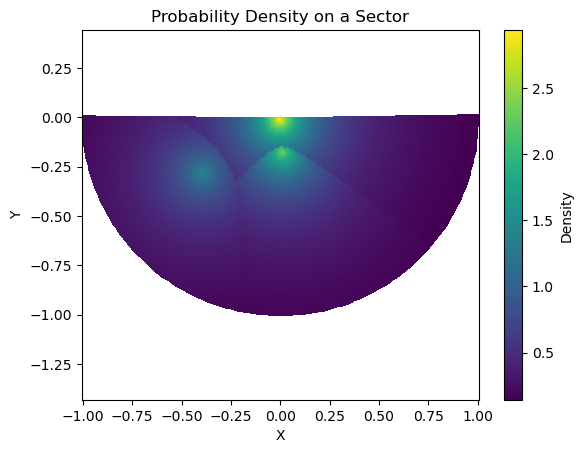

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def plot_sector_density(radius, radian_range, density_function):
    """
    Visualizes the probability density supported on a sector with given radius and radian range.
    
    Parameters:
    - radius: the radius of the sector
    - radian_range: a tuple (start_radian, end_radian) indicating the range of the sector
    - density_function: a function that takes an n by 2 ndarray as arguments; 
      for each row in the ndarray, the first element is the radius, and the second is the radian
    """
    # Create a grid of points
    r = np.linspace(0, radius, 100)
    theta = np.linspace(radian_range[0], radian_range[1], 100)
    R, Theta = np.meshgrid(r, theta)
    
    # Flatten the R and Theta arrays and stack them as n by 2 ndarray where each row is [radius, radian]
    points_narray = np.column_stack((R.ravel(), Theta.ravel()))
    points_narray = torch.from_numpy(points_narray)
    points_narray = torch.tensor(points_narray, device='cuda')
    
    # Compute the density for each point
    Z = density_function(points_narray).reshape(R.shape)
    Z = Z.cpu().numpy()
 
    # Transform the polar coordinates to Cartesian for the plot
    X, Y = R * np.cos(Theta), R * np.sin(Theta)
    
    # Plot the density
    plt.figure()
    plt.pcolormesh(X, Y, Z, shading='auto')
    plt.colorbar(label='Density')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.axis('equal')  # Ensure the aspect ratio is equal to show the sector correctly
    plt.title('Probability Density on a Sector')
    plt.show()

plot_sector_density(region.radius, thetarange, optimal_ftilde)

In [3]:
polyhedron, lambdas_bar, vtilde = optimal_ftilde # When optimization fails, this is the output

TypeError: cannot unpack non-iterable function object

In [4]:
import gurobipy as gp
# Find a feasible solution to the problem first
find_feasible_sol = gp.Model('find_feasible_sol')
find_feasible_sol.setParam('OutputFlag', 0)
x = find_feasible_sol.addMVar(shape=polyhedron.dim, lb=-1, ub=1, name='x')
find_feasible_sol.addConstr(polyhedron.B @ x == polyhedron.c)
find_feasible_sol.addConstr(polyhedron.A @ x <= polyhedron.b - 1e-4)
find_feasible_sol.setObjective(0, gp.GRB.MINIMIZE)
find_feasible_sol.optimize()
# assert find_feasible_sol.status == gp.GRB.OPTIMAL, find_feasible_sol.status
x0 = x.X
print(polyhedron.b - polyhedron.A @ x0)
np.array([polyhedron.A[i, :]/(polyhedron.b[i] - polyhedron.A[i, :] @ x0) for i in range(polyhedron.A.shape[0])])

NameError: name 'polyhedron' is not defined

In [21]:
polyhedron.b  - polyhedron.A @ x0

NameError: name 'polyhedron' is not defined

In [28]:
integrand = lambda X: X[:, 0]*torch.sqrt(optimal_ftilde(X))
simpson = torchquad.Simpson()
area = simpson.integrate(integrand, dim=2, N=9999999, integration_domain=[[0, region.radius],[thetarange[0], thetarange[1]]], backend='torch').item()
print(f"area is {area}.")

area is 1.0283851623535156.


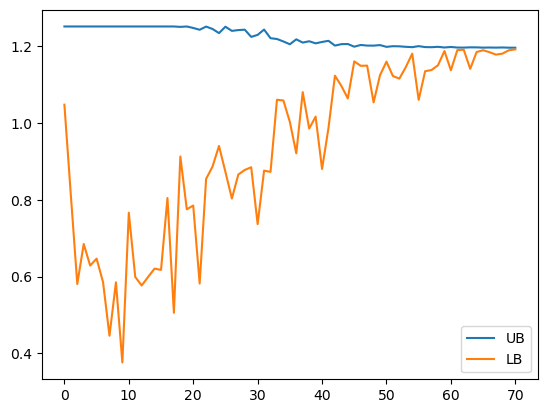

In [12]:
import matplotlib.pyplot as plt

plt.plot(UB_lst, label='UB')
plt.plot(LB_lst, label='LB')
plt.legend()
# plt.yscale('log')
plt.show()

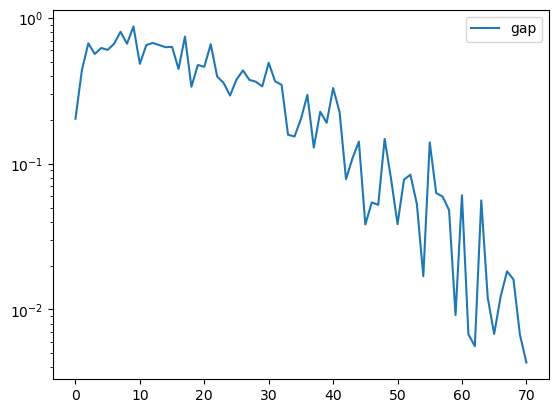

In [13]:
plt.plot(np.array(UB_lst) - np.array(LB_lst), label="gap")
plt.legend()
plt.yscale('log')
plt.show()